In [16]:
from datetime import time as dt_time
import graphviz
import numpy as np
import matplotlib.pyplot as plt
from os import walk
import pandas as pd
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy.stats import zscore
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import Sequential


In [16]:
dfs = []
workload_rawdata_filenames = next(walk("RawData"))[2]

for workload_rawdata_filename in workload_rawdata_filenames:
    workload = workload_rawdata_filename[:-4]
    
    with open(f'RawData/{workload_rawdata_filename}') as f:
        data = []
        
        for line in f:
            i = 79
            words = line[:i].split()
            
            time = dt_time.fromisoformat(words[0][1:-1])
            duration = float(words[1][1:-1]) if  not("?" in words[1][1:-1]) else 0
            device = words[2]
            event = words[3]
            
            
            features = line[i+1:-1].replace("{", "").replace("}", "").split(",")
            features = [f.split("=")[1].strip() for f in features]
            cpu_id = int(features[0])
            name = features[1]
            ino = int(features[2])
            index = int(features[3])
            
            data.append((workload, event, duration, ino, index))
        
        columns = ["workload", "event", "duration", "ino", "index"]
        tracepoints_df = pd.DataFrame(data, columns=columns)
        dfs.append(tracepoints_df)

display(dfs[0].head())

,workload,event,duration,ino,index
0,readrandom,writeback_dirty_page,0.000000,1342340,0
1,readrandom,writeback_dirty_page,0.034154,2805381,128
2,readrandom,writeback_dirty_page,0.000028,2805381,1208
3,readrandom,writeback_dirty_page,0.000002,2805381,966
4,readrandom,writeback_dirty_page,0.662213,2228260,0


In [17]:
#TODO plot tracepoints features

In [18]:
def cumulative_moving_average(x):
    size = x.shape[0]
    return np.cumsum(x) / np.arange(1, size+1)

def cumulative_moving_standard_deviation(x):
    size = x.shape[0]
    return np.sqrt(np.cumsum(x**2) / np.arange(1, size+1) - cumulative_moving_average(x)**2)

def difference(x):
    return x - pd.concat([pd.Series([0]), x[:-1]], ignore_index=True)

def count_last_second(x):
    counts = []
    
    for i in range(len(x)):
        count = 1
        d = x[i]
        
        j = i
        while True:
            if j == 0 or d > 1:
                break
            
            j -= 1
            count += 1
            d += x[j]
            
        counts.append(count)
    
    return pd.Series(counts)
 

In [19]:
new_dfs = []

columns = ["workload", "tracepoints were traced last second", "cumulative moving mean of page offsets", \
    "cumulative moving standard deviation of page offsets", "absolute page offset differences for consecutive tracepoints", "inode number"]

for df in dfs:
    workload = df["workload"]
    count_tracepoints = count_last_second(df["duration"])
    data = zip(df["workload"], count_last_second(df["duration"]), cumulative_moving_average(df["index"]),\
        cumulative_moving_standard_deviation(df["index"]), difference(df["index"]), df["ino"])

    new_dfs.append(pd.DataFrame(data, columns=columns))

OSError: Cannot save file into a non-existent directory: 'ProcessedData'

In [20]:
for i in range(len(new_dfs)):
    new_dfs[i].to_csv(f"ProcessedData/{workload_rawdata_filenames[i][:-4]}.csv", index=False)

whole_data_df = pd.concat(new_dfs, ignore_index=True)
whole_data_df.to_csv("ProcessedData/whole_data.csv", index=False)
display(whole_data_df)

,workload,tracepoints were traced last second,cumulative moving mean of page offsets,cumulative moving standard deviation of page offsets,absolute page offset differences for consecutive tracepoints,inode number
0,readrandom,1,0.000000e+00,0.000000e+00,0,1342340
1,readrandom,2,6.400000e+01,6.400000e+01,128,2805381
2,readrandom,3,4.453333e+02,5.418126e+02,1080,2805381
3,readrandom,4,5.755000e+02,5.205773e+02,-242,2805381
4,readrandom,5,4.604000e+02,5.194157e+02,-966,2228260
...,...,...,...,...,...,...
405763,readseq,5,2.763820e+06,3.841151e+06,-67,2805381
405764,readseq,6,2.691117e+06,3.815985e+06,-101,2805381
405765,readseq,7,2.622114e+06,3.790685e+06,-1061,2805378
405766,readseq,8,2.556583e+06,3.765307e+06,860,2805381


In [8]:
whole_data_df = pd.read_csv("ProcessedData/whole_data.csv")
new_dfs = [pd.read_csv("ProcessedData/readrandom.csv"), pd.read_csv("ProcessedData/readrandomwriterandom.csv"), pd.read_csv("ProcessedData/readreverse.csv"), pd.read_csv("ProcessedData/readseq.csv")]

In [9]:
numeric_cols = whole_data_df.select_dtypes(include=[np.number]).columns
whole_data_df[numeric_cols] = whole_data_df[numeric_cols].apply(zscore)

for df in new_dfs:
    df[numeric_cols] = df[numeric_cols].apply(zscore)

display(whole_data_df)

,workload,tracepoints were traced last second,cumulative moving mean of page offsets,cumulative moving standard deviation of page offsets,absolute page offset differences for consecutive tracepoints,inode number
0,readrandom,-0.732759,-0.144896,-1.252814,-2.926323e-08,-4.379372
1,readrandom,-0.732503,-0.144213,-1.252360,6.418130e-04,2.837389
2,readrandom,-0.732247,-0.140142,-1.248976,5.415515e-03,2.837389
3,readrandom,-0.731990,-0.138752,-1.249126,-1.213512e-03,2.837389
4,readrandom,-0.731734,-0.139981,-1.249135,-4.843933e-03,-0.009383
...,...,...,...,...,...,...
405763,readseq,-0.731734,29.362326,25.954481,-3.359936e-04,2.837389
405764,readseq,-0.731478,28.586123,25.776228,-5.064829e-04,2.837389
405765,readseq,-0.731222,27.849436,25.597027,-5.320300e-03,2.837374
405766,readseq,-0.730966,27.149812,25.417273,4.312349e-03,2.837389


In [31]:
#TODO plot features

In [73]:
X = whole_data_df.iloc[:, 1:]
y = whole_data_df["workload"]

### T-SNE Graph

(767, 5)


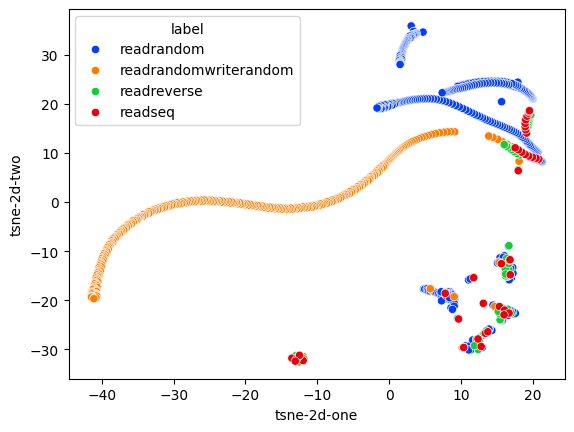

In [74]:
modified_X = X.drop(X.index[range(680,405681)])
modified_y = y.drop(y.index[range(680,405681)])

standardized_data = StandardScaler().fit_transform(modified_X)
print(standardized_data.shape)
 
model = TSNE(n_components = 2, random_state = 0)
tsne_data = model.fit_transform(standardized_data)
tsne_data = np.vstack((tsne_data.T, modified_y)).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("tsne-2d-one", "tsne-2d-two", "label"))
 
sn.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette="bright",
    data=tsne_df)
plt.show()

In [34]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [35]:
skf = StratifiedKFold(n_splits=10, shuffle=True)

accuracies = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    enc = OneHotEncoder()
    enc.fit(y_train.values.reshape(-1, 1))
    y_train = pd.DataFrame(enc.transform(y_train.values.reshape(-1, 1)).toarray(), columns=enc.categories_[0])
    y_test = pd.DataFrame(enc.transform(y_test.values.reshape(-1, 1)).toarray(), columns=enc.categories_[0])
    
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracies.append(accuracy)
    
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print("Accuracy: %.2f%% (+/- %.2f%%)" % (mean_accuracy * 100, std_accuracy * 100))

KeyboardInterrupt: 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100))

Accuracy: 99.98%


In [ ]:
feature_names = X.columns
class_names = y.unique()

dot_data = export_graphviz(model, out_file=None, feature_names=feature_names, class_names=class_names)

graph = graphviz.Source(dot_data)
graph.render("decision_tree")

'decision_tree.pdf'